**Возникли следующие вопросы:**
- Dice-коэффициент низкий и маска как будто не предсказывается (на выходе матрица из нулей часто). Может маску тоже нужно через свертку провести? Может у меня функция Dice некорректно написана? Сломала голову... Как с данным сетом можно добиться лучших метрик?
- Обяъясните, пожалуйста, как для transforms.Normalize() расчитать цифры `mean`, `std`. Я правильно понимаю, что высчитавется среднее и сигма по каждому каналу (если это так, то как это посчитать?)? Или это фиксированные значения? Или они подбираются?

**Алгоритм обучения:**
1. EDA: Загружены тренировочный и тестовый сеты, файл с информацией о метка класса предобработан
2. DATALOADER:
    * фото итерируются на основе файла `train_df`, в котором данные о классах и масках
    * сведения из этого файла сверяются с папкой с назвааниями фото. Фото переходит в `Grayscale` и прогоняется через фильтр `Canny` а-ля Соболь. Полученная матрица переводится в тензор
    * затем пиксели маски тренировочного и валидационного сета раскодируются в бинарную матрицу и так же переводятся в тензон
    * в итоге для тренировочного и валидационного сета Dataloader подготавливает логиты фото, его метки класса и маски - все в формате тензор-матриц
    * для тестовой выборки готовится тензор-матрица логитов фото и ее название
4. Обучение ConvNeuralNet с тремя сверточными слоями и двумя линейными для вывода `метка класса` + `матрица`. Лосс-функция - `BCEWithLogitsLoss`
5. Визуализация прогресса обучения и валидации
6. Тестирование

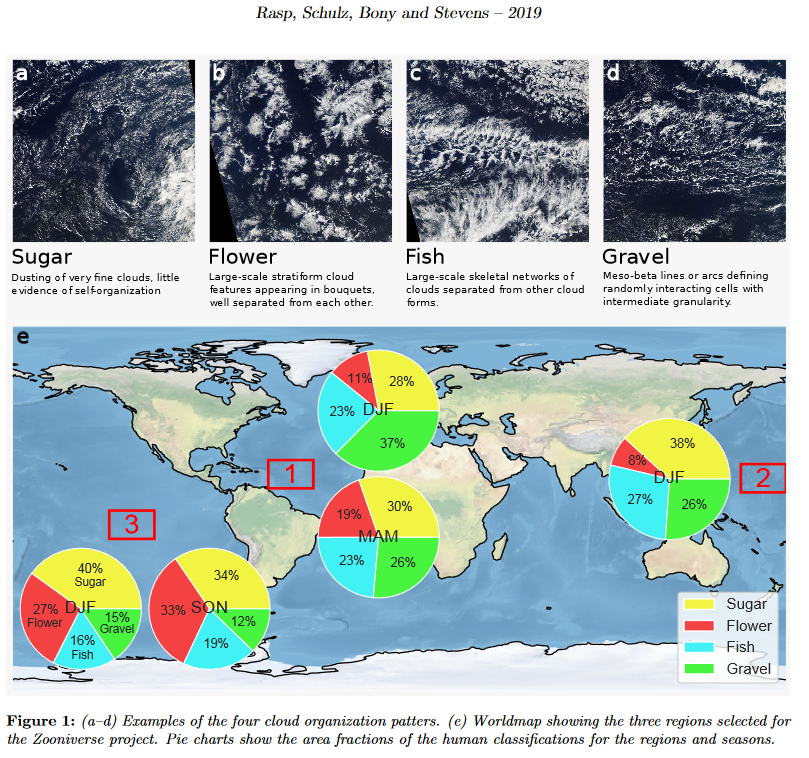

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
# from torchvision.transforms import v2, InterpolationMode
# import torch.nn.functional as F
# from torchvision import transforms as T
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## EDA

Load data:

In [2]:
train_folder = 'C:/Users/Anastasia Volkova/Downloads/train_images/'
test_folder = 'C:/Users/Anastasia Volkova/Downloads/test_images/'
train_df = pd.read_csv('Z:/VScode/KAGGLE/homework10/train.csv')

splitted = train_df['Image_Label'].str.split(pat='_', expand=True)

train_df['Image'] = splitted[0]
train_df['Label'] = splitted[1]

train_df.head()

,Image_Label,EncodedPixels,Image,Label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
 2   Image          22184 non-null  object
 3   Label          22184 non-null  object
dtypes: object(4)
memory usage: 693.4+ KB


In [4]:
train_df.iloc[:, 3].value_counts()

Label
Fish      5546
Flower    5546
Gravel    5546
Sugar     5546
Name: count, dtype: int64

Drawing the edges:

In [5]:
def get_image(folder, idx: int):
    if idx < 0 or idx >= len(folder):
        raise IndexError('Index is out of range')
    image_dir = os.listdir(folder)
    image_name = image_dir[idx]
    image_path = os.path.join(folder, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, image_name

def get_edge(image, threshold1, threshold2):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.Canny(gray_image, threshold1, threshold2)
    return edge_image

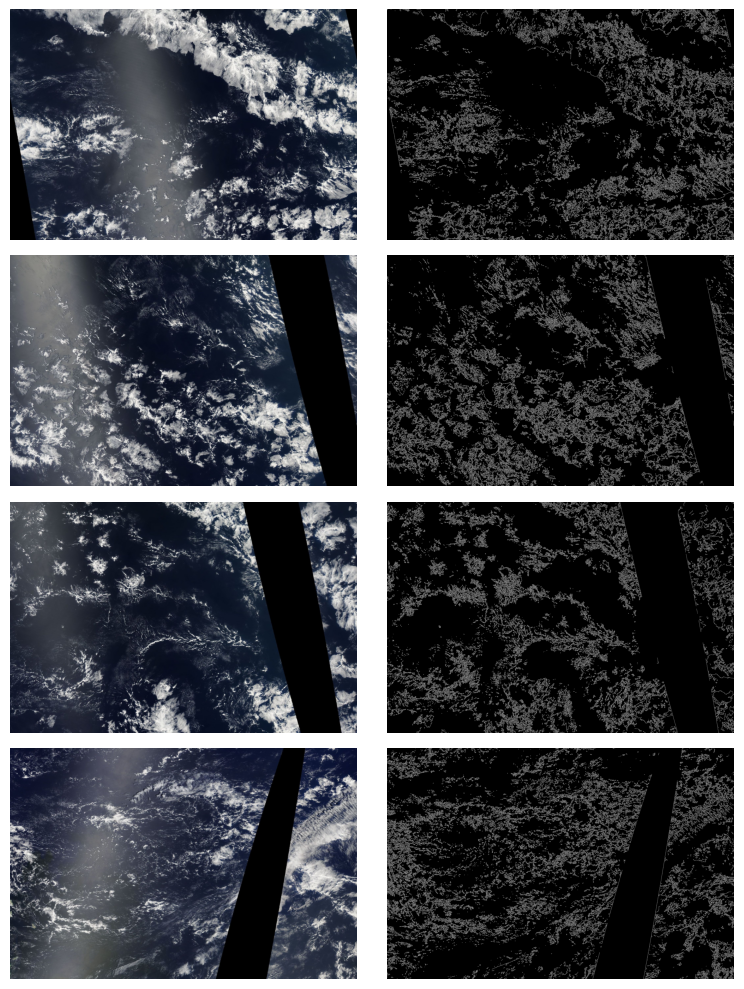

In [6]:
threshold1 = 150
threshold2 = 250

orig_images = []
edged_images = []

for i in range(1, 5):
    image = get_image(train_folder, i)[0]
    orig_images.append(image)
    edge_image = get_edge(image, threshold1, threshold2)
    edged_images.append(edge_image)

plt.figure(figsize=(8, 10))
for i in range(4):
    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(orig_images[i])
    plt.axis('off')
    
    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(edged_images[i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Get the mask:

In [7]:
shape = (1400, 2100)

def rle_decode(encoded_pixels, shape=shape):
    encoded_pixels = encoded_pixels.split()

    starts = np.array(encoded_pixels[0::2], dtype=np.int32, copy=False) - 1
    lengths = np.array(encoded_pixels[1::2], dtype=int, copy=False)

    ends = starts + lengths

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1
    return np.reshape(mask, shape, order='F')

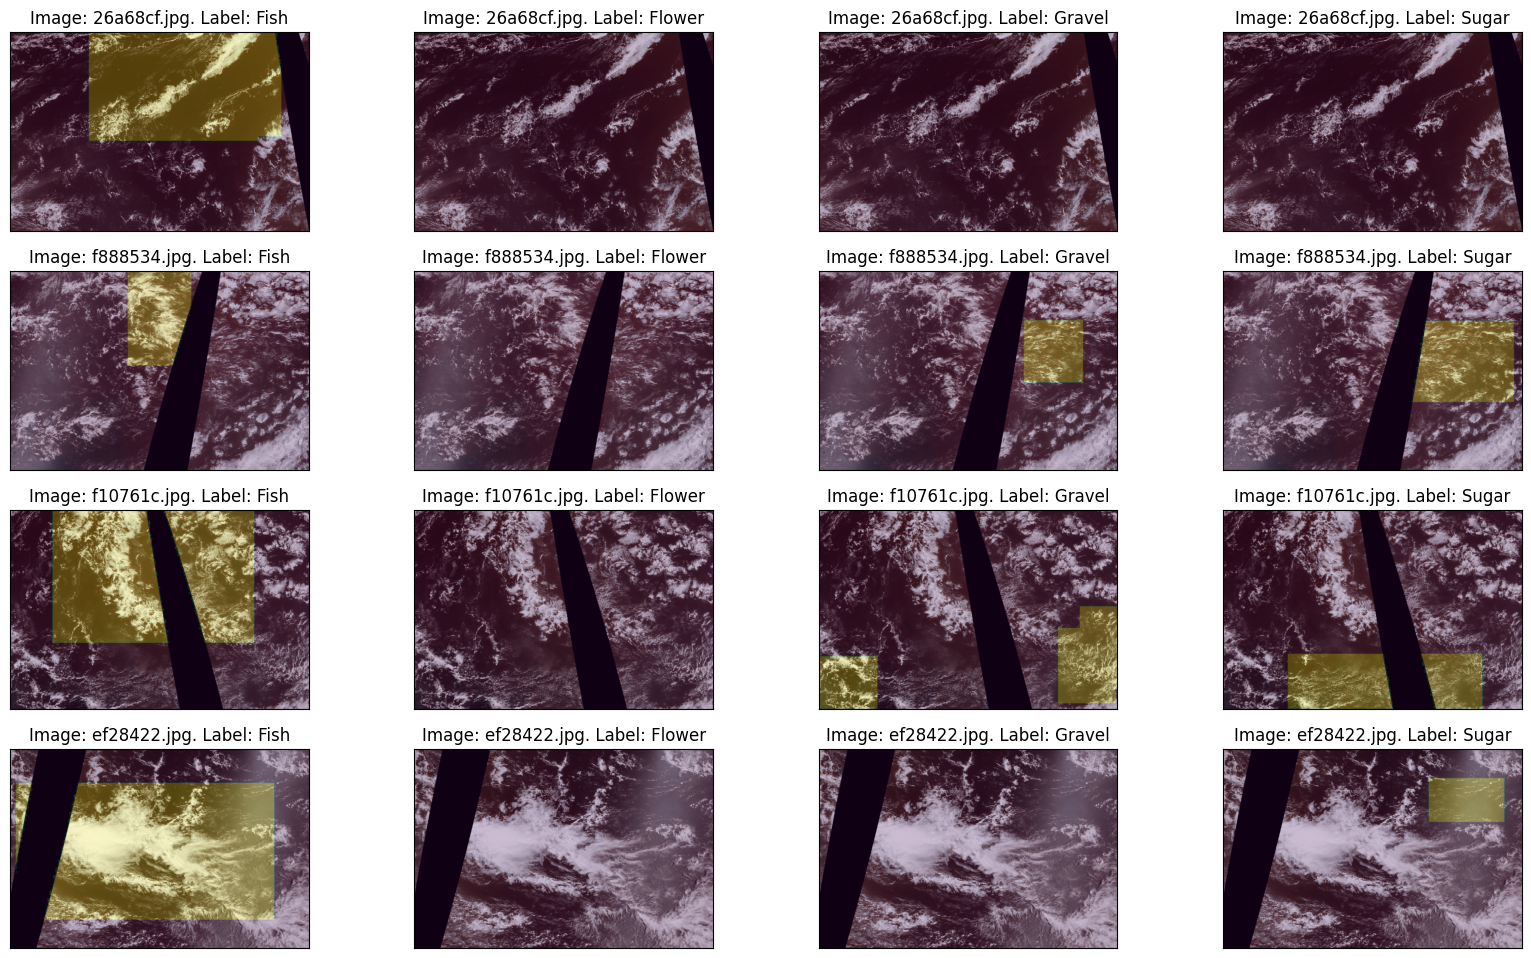

In [8]:
fig = plt.figure(figsize=(20, 15))
for j, image_name in enumerate(np.random.choice(train_df['Image'].unique(), 4)):
    for i, (idx, row) in enumerate(train_df.loc[train_df['Image'] == image_name].iterrows()):
        image_name = row['Image']
        label = row['Label']
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        image = cv2.imread(f"{train_folder}{image_name}")
        plt.imshow(image)
        encoded_pixels = row['EncodedPixels']
        try:
            mask = rle_decode(encoded_pixels)
        except:
            mask = np.zeros((1400, 2100))
        plt.imshow(mask, alpha=0.25)
        ax.set_title(f"Image: {image_name}. Label: {label}")

Encode labels:

In [9]:
dummies = pd.get_dummies(train_df['Label'], dtype=int)
train_df = train_df.drop(columns=['Image_Label', 'Label'])
train_df = pd.concat([train_df, dummies], axis=1)
train_df['EncodedPixels'] = train_df['EncodedPixels'].fillna(-1)

train_df.head()

,EncodedPixels,Image,Fish,Flower,Gravel,Sugar
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,1,0,0,0
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,0,1,0,0
2,-1,0011165.jpg,0,0,1,0
3,-1,0011165.jpg,0,0,0,1
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,1,0,0,0


## Model

Split the data on `train`, `validation` and `test` datasets. Converting images to tensors and normalizing them.

In [10]:
# transforms = v2.Compose([
#     v2.Resize(size=[525, 350], interpolation=InterpolationMode.NEAREST),
#     v2.Grayscale(),
#     v2.RandomHorizontalFlip(p=0.3),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize([0.5, 0.5, 0.5]),
#     v2.ToTensor(),
#     v2.functional.permute_channels(1, 0).unsqueeze(0)
# ])
# img = transforms(img)

In [11]:
class CloudDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, train=True):
        super().__init__()
        self.folder_path = folder_path
        if folder_path == train_folder:
            self.image_dir = os.listdir(train_folder)
            self.train_df = train_df
            self.train_classes = self.train_df.iloc[:16639]
            self.val_classes = self.train_df.iloc[16639:]
            if train==True:
                self.data = self.train_classes
            else:
                self.data = self.val_classes
        else:
            self.image_dir = os.listdir(test_folder)
            self.data = self.image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.folder_path == train_folder:
            image_name = self.data.iloc[idx]['Image']
            image_path = os.path.join(self.folder_path, image_name)
            image_label = self.data.iloc[idx][2:].values.astype(np.float32)
            tensor_label = torch.from_numpy(image_label)
            tensor_image = self.image_predproc(image_path)
            
            encoded_pixels = self.data.iloc[idx]['EncodedPixels']
            mask = rle_decode(encoded_pixels) if encoded_pixels is not -1 else np.zeros(shape)  #
            mask = mask.astype(np.float32)
            mask = cv2.resize(mask, dsize=(525, 350), interpolation=cv2.INTER_AREA)  #
            tensor_mask = torch.from_numpy(mask).unsqueeze(0)

            return tensor_image, tensor_label, tensor_mask, image_name
        else:
            image_name = self.data[idx]
            image_path = os.path.join(self.folder_path, image_name)
            tensor_image = self.image_predproc(image_path)
            return tensor_image, image_name
    
    def image_predproc(self, image_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.Canny(image, threshold1, threshold2)
        image = image.astype(np.float32)
        image = image/255.0
        image = cv2.resize(image, dsize=(525, 350), interpolation=cv2.INTER_AREA)  # 4 times less
        image = torch.from_numpy(image).unsqueeze(0)
        return image

In [12]:
train = CloudDataset(train_folder, train=True)
val = CloudDataset(train_folder, train=False)
test = CloudDataset(test_folder, train=False)

len(train), len(val), len(test)

(16639, 5545, 3698)

Model outputs:

In [13]:
print(f'Class matrix: {train[0][1]}')
print(f'Shape of photo: {train[0][0].size()}')
print(f'Shape of mask: {train[0][2].size()}')

Class matrix: tensor([1., 0., 0., 0.])
Shape of photo: torch.Size([1, 350, 525])
Shape of mask: torch.Size([1, 350, 525])


In [14]:
print(f'Shape of photo: {test[0][0].size()}')
print(f'Name of photo: {test[0][1]}')

Shape of photo: torch.Size([1, 350, 525])
Name of photo: 002f507.jpg


Create the dataloaders:

In [15]:
batch_size=64

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

test_loader = DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

Create the model:

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.Sequential(                                                 # 100*1*350*525
            nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1),     # 100*5*350*525
            # nn.BatchNorm2d(num_features=5),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                                   # 100*5*175*262
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1),
            # nn.BatchNorm2d(num_features=10),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=3)                                    # 100*10*58*87
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, padding=1),
            # nn.BatchNorm2d(num_features=15),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=4, stride=4)                                    # 100*15*14*21
        )

        self.class_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=15*14*21, out_features=600),
            # nn.Dropout2d(p=0.25),
            nn.Linear(in_features=600, out_features=4),
            nn.Softmax()                                                             # 4 classes
        )

        self.mask_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=15*14*21, out_features=350*525),
            nn.Sigmoid()                                                             # или nn.Softmax?
        )

    def forward(self, x):
        out = self.conv0(x)
        out = self.conv1(out)
        out = self.conv2(out)
        class_output = self.class_fc(out)
        mask_output = self.mask_fc(out)
        mask_output = mask_output.view(-1, 1, 350, 525)
        return class_output, mask_output

In [18]:
model = CNN().to(device)
model

CNN(
  (conv0): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): Sequential(
    (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (class_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4410, out_features=600, bias=True)
    (2): Linear(in_features=600, out_features=4, bias=True)
    (3): Softmax(dim=None)
  )
  (mask_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4410, out_features=183750, bias=True)
    (2): Sigm

In [19]:
for layer, param in model.named_parameters():
    if param.requires_grad:
        print(f'Layer: {layer}, Size: {param.size()}')

Layer: conv0.0.weight, Size: torch.Size([5, 1, 3, 3])
Layer: conv0.0.bias, Size: torch.Size([5])
Layer: conv1.0.weight, Size: torch.Size([10, 5, 3, 3])
Layer: conv1.0.bias, Size: torch.Size([10])
Layer: conv2.0.weight, Size: torch.Size([15, 10, 3, 3])
Layer: conv2.0.bias, Size: torch.Size([15])
Layer: class_fc.1.weight, Size: torch.Size([600, 4410])
Layer: class_fc.1.bias, Size: torch.Size([600])
Layer: class_fc.2.weight, Size: torch.Size([4, 600])
Layer: class_fc.2.bias, Size: torch.Size([4])
Layer: mask_fc.1.weight, Size: torch.Size([183750, 4410])
Layer: mask_fc.1.bias, Size: torch.Size([183750])


Train the model:

In [20]:
import gc
torch.cuda.empty_cache()
gc.collect()

13592

In [21]:
def dice_func(pred, orig, epsilon=1e-8):
    """
    size [Batch, Class, Hight, Weight] for predicted and original.
    
    """
    pred = torch.sigmoid(pred) > 0.5
    intersection = torch.sum(pred * orig)
    dice = (2 * intersection + epsilon) / (torch.sum(pred) + torch.sum(orig) + epsilon)
    return dice.item()

In [22]:
loss_func_class = nn.CrossEntropyLoss()
loss_func_mask = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.00001)

train_loss_stat = []
train_dice_stat = []
epochs = 5
for epoch in range(epochs):
    model.train()
    print(f'Epoch {epoch+1}/{epochs}')
          
    for iteration, batch in enumerate(train_loader):
        image, label, mask, _ = batch[0].to(device), \
                                batch[1].to(device), \
                                batch[2].to(device), \
                                batch[3]
        train_pred_class, train_pred_mask = model(image)
        train_loss_class = loss_func_class(train_pred_class, label)
        train_loss_mask = loss_func_mask(train_pred_mask, mask)
        train_loss = train_loss_class + train_loss_mask
        train_dice_coef = dice_func(train_pred_mask, mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if iteration % 20 == 0:
            train_loss_stat.append(train_loss.item())
            train_dice_stat.append(train_dice_coef)
            print(f'Iteration: {iteration}, train loss: {train_loss.item():.6f}, Dice: {train_dice_coef:.6f}')


Epoch 1/5
Iteration: 0, train loss: 2.303372, Dice: 0.199525
Iteration: 20, train loss: 2.284268, Dice: 0.246030
Iteration: 40, train loss: 2.264615, Dice: 0.251652
Iteration: 60, train loss: 2.249537, Dice: 0.280068
Iteration: 80, train loss: 2.250296, Dice: 0.232820
Iteration: 100, train loss: 2.238646, Dice: 0.225467
Iteration: 120, train loss: 2.224752, Dice: 0.257257
Iteration: 140, train loss: 2.225959, Dice: 0.171380
Iteration: 160, train loss: 2.207929, Dice: 0.206889
Iteration: 180, train loss: 2.184742, Dice: 0.267812
Iteration: 200, train loss: 2.169515, Dice: 0.273368
Iteration: 220, train loss: 2.166398, Dice: 0.269695
Iteration: 240, train loss: 2.157793, Dice: 0.240067
Epoch 2/5
Iteration: 0, train loss: 2.154737, Dice: 0.230753
Iteration: 20, train loss: 2.143074, Dice: 0.262008
Iteration: 40, train loss: 2.142185, Dice: 0.185976
Iteration: 60, train loss: 2.117305, Dice: 0.265349
Iteration: 80, train loss: 2.123205, Dice: 0.282288
Iteration: 100, train loss: 2.116888, 

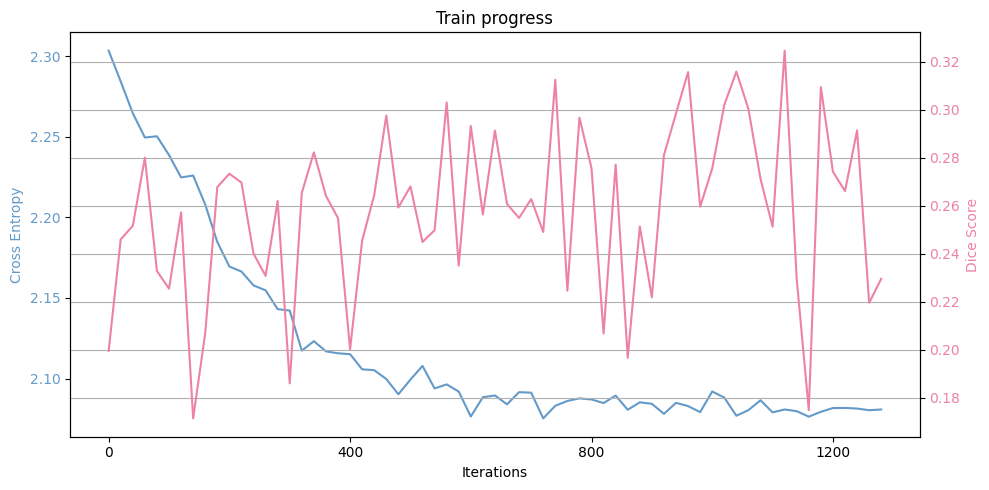

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Iterations')
ticks = np.arange(0, 2400, 20)
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks * 20)
ax1.set_ylabel('Cross Entropy', color='#639ac9')
ax1.plot(train_loss_stat, color='#639ac9')
ax1.tick_params(axis='y', labelcolor='#639ac9')

ax2 = ax1.twinx()
ax2.set_ylabel('Dice Score', color='#ed82a4')
ax2.plot(train_dice_stat, color='#ed82a4')
ax2.tick_params(axis='y', labelcolor='#ed82a4')

plt.title('Train progress')
plt.tight_layout()
plt.grid(True)
plt.show()

Validate the model:

In [24]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_score = 0
        self.early_stop = False

    def call(self, val_loss):
        score = val_loss
        if score > self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                    self.early_stop = True

In [25]:
val_loss_stat = []
val_dice_stat = []
val_results = []
early_stopping = EarlyStopping(patience=10)
max_dice = 0

model.eval()
with torch.no_grad():
    for iteration, batch in enumerate(val_loader):
        image, label, mask, image_name = batch[0].to(device), \
                                         batch[1].to(device), \
                                         batch[2].to(device), \
                                         batch[3]
        val_pred_class, val_pred_mask = model(image)
        for i in range(val_pred_class.size(0)):
            val_results.append({
                'Image': image_name[i],
                'Label': val_pred_class[i].cpu().numpy(),
                'Mask': val_pred_mask[i].cpu().numpy()
                })
        
        val_loss_class = loss_func_class(val_pred_class, label)
        val_loss_mask = loss_func_mask(val_pred_mask, mask)
        val_loss = val_loss_class + val_loss_mask
        val_dice_coef = dice_func(val_pred_mask, mask)
        val_loss_stat.append(val_loss.item())
        val_dice_stat.append(val_dice_coef)
        
        if max_dice < np.mean(np.array(val_dice_coef)):
            torch.save(model.state_dict(), f'cnn.pth')
            max_dice = np.mean(np.array(val_dice_coef))
            print(f'Iteration: {iteration}, validation loss: {val_loss.item():.6f}, Dice: {val_dice_coef:.6f}.\n\
                    === Model saved ===')
            
        early_stopping.call(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print(f'Iteration: {iteration}, validation loss: {val_loss.item():.6f}, Dice: {val_dice_coef:.6f}.\n\
                  === Validation stopped ===')
            break

Iteration: 0, validation loss: 2.081004, Dice: 0.273942.
                    === Model saved ===
Iteration: 1, validation loss: 2.085661, Dice: 0.284372.
                    === Model saved ===
Iteration: 4, validation loss: 2.078691, Dice: 0.301561.
                    === Model saved ===
Iteration: 19, validation loss: 2.076599, Dice: 0.285201.
                  === Validation stopped ===


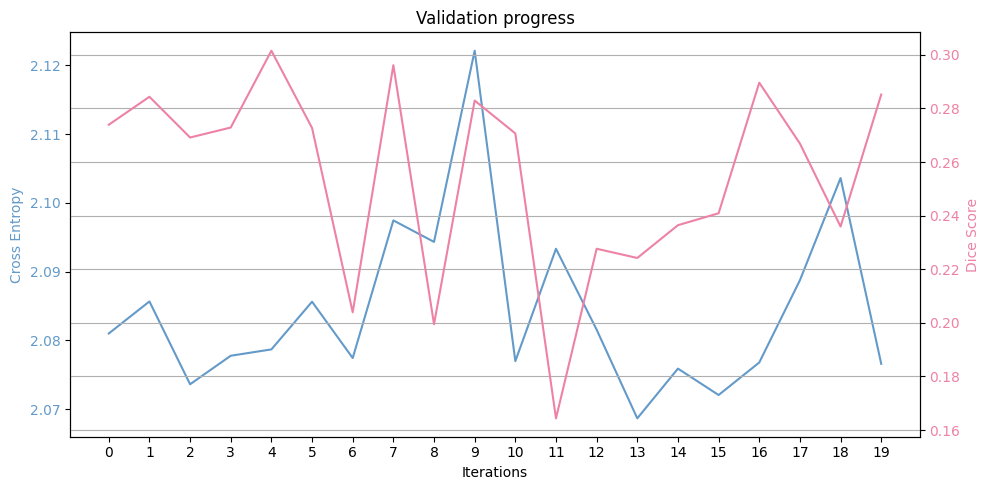

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Iterations')
ticks = np.arange(0, 100)
# labels = ticks * 20
ax1.set_xticks(ticks)
ax1.set_ylabel('Cross Entropy', color='#639ac9')
ax1.plot(val_loss_stat, color='#639ac9')
ax1.tick_params(axis='y', labelcolor='#639ac9')

ax2 = ax1.twinx()
ax2.set_ylabel('Dice Score', color='#ed82a4')
ax2.plot(val_dice_stat, color='#ed82a4')
ax2.tick_params(axis='y', labelcolor='#ed82a4')

plt.title('Validation progress')
plt.tight_layout()
plt.grid(True)
plt.show()

In [27]:
def postproc(result_dict):
    results_df = pd.DataFrame(result_dict)
    results_df['Mask'] = results_df['Mask'].apply(lambda x: (x > 0.5).astype(float))
    for idx, row in enumerate(results_df['Label']):
        max_idx = np.argmax(row)
        if max_idx == 0:
            results_df['Label'][idx] = 'Fish'
        elif max_idx == 1:
            results_df['Label'][idx] = 'Flower'
        elif max_idx == 2:
            results_df['Label'][idx] = 'Gravel'
        else:
            results_df['Label'][idx] = 'Sugar'
    return results_df

Test the model:

In [28]:
# torch.cuda.empty_cache()
# gc.collect()

: 

In [29]:
test_results = []

model.eval()
with torch.no_grad():
    for iteration, batch in enumerate(test_loader):
        image, image_name = batch[0].to(device), batch[1]
        test_pred_class, test_pred_mask = model(image)
        for i in range(test_pred_class.size(0)):
            test_results.append({
                'Image': image_name[i],
                'Label': test_pred_class.cpu(),
                'Mask': test_pred_mask.cpu()
                })

In [ ]:
test_results[0]